In [1]:
import torch
import numpy as np
from torchvision import transforms as mtf
import pandas as pd
import os
import os.path as osp
import matplotlib.pyplot as plt
import nibabel as nib
import seaborn as sns
from pathlib import Path
import sys

from src.models.llm.medclip import *

/home/rczx/miniconda3/envs/ntrain/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os

os.environ["HTTP_PROXY"] = "http://127.0.0.1:18080"
os.environ["HTTPS_PROXY"] = "http://127.0.0.1:18080"

In [6]:
from src.utils.medical.image_utils import NiiGZData
from torch.amp import GradScaler, autocast

texts = ["healthy", "abnormal"]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data = NiiGZData(
    "/media/rczx/Data/data/BrainMD_dataset/BrainMD/Choroid_plexus/206/26775619/T1C/T1C_0_11.nii.gz"
)

image_slice = data.select(slice_idx=11, direction=-1)
image_slice = torch.from_numpy(image_slice).unsqueeze(0).unsqueeze(0)

scaler = GradScaler()
model = build_medclip()
model.from_pretrained()
model = model.to(device)

image_slice = image_slice.float().to(device)

model.eval()
with autocast(device.type, dtype=torch.float16):
    outputs = model.encode_image(image_slice)
print(outputs.shape)

RuntimeError: Error(s) in loading state_dict for MedCLIPModel:
	Unexpected key(s) in state_dict: "text_model.model.embeddings.position_ids". 

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
/home/rczx/miniconda3/envs/ntrain/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


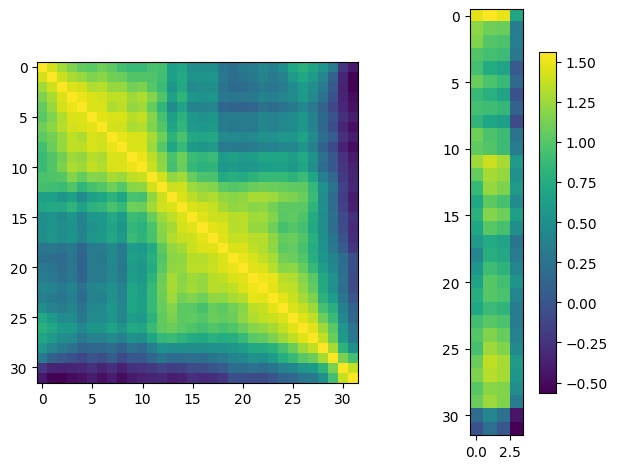

类别 'MRI' 的平均占比: 0.2663
类别 'A brain MRI without abnormal findings' 的平均占比: 0.3015
类别 'A brain MRI showing abnormal findings' 的平均占比: 0.2800
类别 'Brain MRI with malignant lesion' 的平均占比: 0.1523
Final image_feats shape: torch.Size([32, 512]), dtype: torch.float32
Similarity matrix shape: torch.Size([32, 4]), dtype: torch.float32


In [4]:
from torchvision import transforms as mtf
import torch.nn.functional as F
from libs.MedCLIP.medclip.modeling_medclip import (
    MedCLIPModel,
    MedCLIPVisionModelViT,
)  # 也可用 MedCLIPVisionModel

texts = [
    "MRI",
    "A brain MRI without abnormal findings",
    "A brain MRI showing abnormal findings",
    "Brain MRI with malignant lesion",
]

IMG_MEAN = 0.5862785803043838
IMG_STD = 0.27950088968644304

resize = mtf.Compose(
    [
        mtf.Resize((224, 224)),
        mtf.ToTensor(),
    ]
)

model.eval()
with torch.no_grad():
    input_ids = model.text_model.tokenizer(
        texts, padding=True, truncation=True, return_tensors="pt"
    )["input_ids"].cuda()
    text_feat = model.encode_text(input_ids)
    image_feats = []
    with autocast(device.type, dtype=torch.float16):
        for i in range(data.fdata.shape[-1]):
            x = data.fdata[..., i].astype("float32")  # (H, W) numpy -> float32
            x = torch.from_numpy(x)  # torch.Tensor (H, W)

            x = x.unsqueeze(0).unsqueeze(0)  # (1, 1, H, W)
            x = F.interpolate(
                x, size=(224, 224), mode="bilinear", align_corners=True
            )  # (1,1,224,224)
            x = x.repeat(1, 3, 1, 1)  # (1,3,224,224)
            x = (x - IMG_MEAN) / IMG_STD
            x = x.to(device)

            image_feat = model.encode_image(x)
            image_feats.append(image_feat)

image_feats = torch.cat(image_feats, dim=0)

# sim = image_feats @ image_feats.T
sim = model.compute_logits(image_feats, image_feats)
plt.subplot(1, 2, 1)
plt.imshow(sim.detach().cpu().numpy())
# sim = image_feats @ text_feat.T
sim = model.compute_logits(image_feats, text_feat)
plt.subplot(1, 2, 2)
plt.imshow(sim.detach().cpu().numpy())
plt.colorbar(shrink=0.8)
plt.tight_layout()
plt.show()
# 对相似度矩阵进行softmax归一化，得到每个类别的概率分布
sim = sim.softmax(dim=-1)

# 计算每个类别的平均概率
class_proportions = sim.mean(dim=0)

# 打印每个类别的占比
for i, (text, prop) in enumerate(zip(texts, class_proportions)):
    print(f"类别 '{text}' 的平均占比: {prop.item():.4f}")

print(f"Final image_feats shape: {image_feats.shape}, dtype: {image_feats.dtype}")
print(f"Similarity matrix shape: {sim.shape}, dtype: {sim.dtype}")

In [5]:
from pathlib import Path

ROOT_DIR = "/media/rczx/Data/data/MRI_BRAIN_CLIP"
base_dir = Path(ROOT_DIR)

cancer_types = [d.name for d in base_dir.iterdir()]
image_paths = {ct: [d for d in (base_dir / ct).glob("*.png") if not d.name.endswith("_mask.png")] for ct in cancer_types}

from pprint import pprint
pprint(cancer_types)
pprint(image_paths)


['Pituitary tumor', 'Meningioma', 'Glioma']
{'Glioma': [PosixPath('/media/rczx/Data/data/MRI_BRAIN_CLIP/Glioma/2903.png'),
            PosixPath('/media/rczx/Data/data/MRI_BRAIN_CLIP/Glioma/1863.png'),
            PosixPath('/media/rczx/Data/data/MRI_BRAIN_CLIP/Glioma/2708.png'),
            PosixPath('/media/rczx/Data/data/MRI_BRAIN_CLIP/Glioma/2684.png'),
            PosixPath('/media/rczx/Data/data/MRI_BRAIN_CLIP/Glioma/856.png'),
            PosixPath('/media/rczx/Data/data/MRI_BRAIN_CLIP/Glioma/2321.png'),
            PosixPath('/media/rczx/Data/data/MRI_BRAIN_CLIP/Glioma/801.png'),
            PosixPath('/media/rczx/Data/data/MRI_BRAIN_CLIP/Glioma/2922.png'),
            PosixPath('/media/rczx/Data/data/MRI_BRAIN_CLIP/Glioma/1914.png'),
            PosixPath('/media/rczx/Data/data/MRI_BRAIN_CLIP/Glioma/2907.png'),
            PosixPath('/media/rczx/Data/data/MRI_BRAIN_CLIP/Glioma/2524.png'),
            PosixPath('/media/rczx/Data/data/MRI_BRAIN_CLIP/Glioma/2173.png'),
          